# Decision Tree Training & Evaluation Pipeline 

This notebook automates data loading, preprocessing, model training with hyperparameter tuning, evaluation, and basic visualizations for our Heron WellNest project.

## Setup and Imports

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

## Configurations


In [2]:
DATA_PATH = '../../data/classification/synthetic_dataset.csv'
# Path where the trained model will be saved
MODEL_PATH = '../../models/classification/decision-tree.joblib'

## Load Data


In [3]:
df = pd.read_csv(DATA_PATH)

target_col = 'WellbeingClass'

labels = df[target_col].unique()
feature_cols = ["p_anxiety", "p_normal", "p_depression", "p_suicidal", "p_stress", "gratitude_flag",
                "Depressed","Sad","Exhausted","Hopeless","Anxious",
                "Angry","Stressed","Restless","Calm","Relaxed",
                "Peaceful","Content","Happy","Energized","Excited",'Motivated']

print(df[target_col].value_counts())
df.head()

WellbeingClass
Struggling    3771
Thriving      2728
InCrisis      2598
Excelling      903
Name: count, dtype: int64


,p_anxiety,p_normal,p_depression,p_suicidal,p_stress,gratitude_flag,WellbeingClass,Depressed,Sad,Exhausted,...,Peaceful,Content,Happy,Energized,Excited,Motivated,flipfeel_incrisis_pct,flipfeel_struggling_pct,flipfeel_thriving_pct,flipfeel_excelling_pct
0,0.140475,0.181060,0.330063,0.135326,0.213077,0,Struggling,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,1,Excelling,0,0,0,...,0,0,1,0,0,1,0.4,0.0,0.0,0.6
2,0.000000,0.000000,0.000000,0.000000,0.000000,0,Thriving,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0,Struggling,0,0,0,...,0,0,0,0,0,0,0.0,1.0,0.0,0.0
4,0.009923,0.071636,0.357258,0.424961,0.136221,0,InCrisis,0,1,0,...,0,0,0,0,0,0,1.0,0.0,0.0,0.0


## Data visualization


## Data Pre-processing


Before dropping:
p_anxiety         0
p_normal          0
p_depression      0
p_suicidal        0
p_stress          0
gratitude_flag    0
Depressed         0
Sad               0
Exhausted         0
Hopeless          0
Anxious           0
Angry             0
Stressed          0
Restless          0
Calm              0
Relaxed           0
Peaceful          0
Content           0
Happy             0
Energized         0
Excited           0
Motivated         0
dtype: int64

After dropping:
p_anxiety         0
p_normal          0
p_depression      0
p_suicidal        0
p_stress          0
gratitude_flag    0
Depressed         0
Sad               0
Exhausted         0
Hopeless          0
Anxious           0
Angry             0
Stressed          0
Restless          0
Calm              0
Relaxed           0
Peaceful          0
Content           0
Happy             0
Energized         0
Excited           0
Motivated         0
dtype: int64


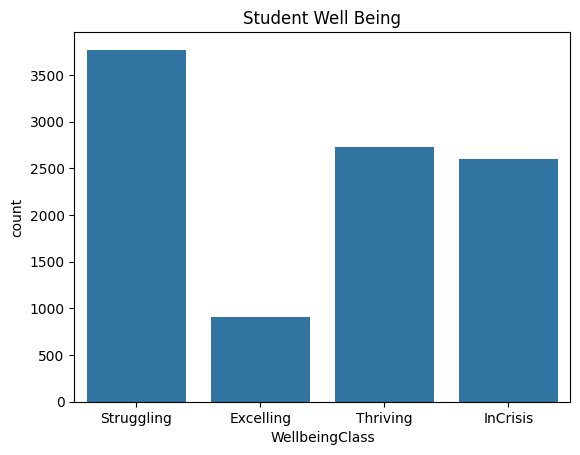

In [4]:
# Check for missing values
print("Before dropping:")
print(df[feature_cols].isna().sum())


# Drop the missing values
df = df.dropna()

# Check if missing values were dropped
print("\nAfter dropping:")
print(df[feature_cols].isna().sum())

# Class distribution
sns.countplot(x=target_col, data=df)
plt.title('Student Well Being')
plt.show()

In [5]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Encode categorical features before splitting
X_encoded = pd.get_dummies(X)

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print("Training set features dtype:\n", X_train.dtypes.unique())  # Should show only numeric types

Training set features dtype:
 [dtype('float64') dtype('int64')]


## Model training


In [6]:
dt_pipeline = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Param grid
dt_param_grid = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# GridSearchCV setup
grid_search_dt = GridSearchCV(
    dt_pipeline,
    dt_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit on original (imbalanced) training data
grid_search_dt.fit(X_train, y_train)

# Save best model
best_model = grid_search_dt.best_estimator_
joblib.dump(best_model, MODEL_PATH)

print("✅ Best Parameters:", grid_search_dt.best_params_)

✅ Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}


## Model Evaluation


✅ Cross-Validation Results Summary:



,mean_test_score,std_test_score,params
0,0.888220,0.009653,"{'classifier__criterion': 'entropy', 'classifi..."
1,0.888220,0.009653,"{'classifier__criterion': 'entropy', 'classifi..."
2,0.888220,0.009653,"{'classifier__criterion': 'entropy', 'classifi..."
3,0.887925,0.011661,"{'classifier__criterion': 'entropy', 'classifi..."
4,0.887925,0.011661,"{'classifier__criterion': 'entropy', 'classifi..."
...,...,...,...
91,0.576214,0.017894,"{'classifier__criterion': 'entropy', 'classifi..."
92,0.576214,0.017894,"{'classifier__criterion': 'entropy', 'classifi..."
93,0.576103,0.017907,"{'classifier__criterion': 'entropy', 'classifi..."
94,0.576103,0.017907,"{'classifier__criterion': 'entropy', 'classifi..."



📊 Classification Report (Test Set):



,precision,recall,f1-score,support
Excelling,0.783,0.757,0.770,181.000
InCrisis,0.935,0.915,0.925,520.000
Struggling,0.887,0.908,0.898,754.000
Thriving,0.860,0.859,0.860,545.000
accuracy,0.883,0.883,0.883,0.883
macro avg,0.866,0.860,0.863,2000.000
weighted avg,0.883,0.883,0.883,2000.000



⚖️ Balanced Accuracy: 0.8599

🔎 Confusion Matrix:



,Pred_Excelling,Pred_InCrisis,Pred_Struggling,Pred_Thriving
True_Excelling,137,3,13,28
True_InCrisis,9,476,27,8
True_Struggling,11,18,685,40
True_Thriving,18,12,47,468


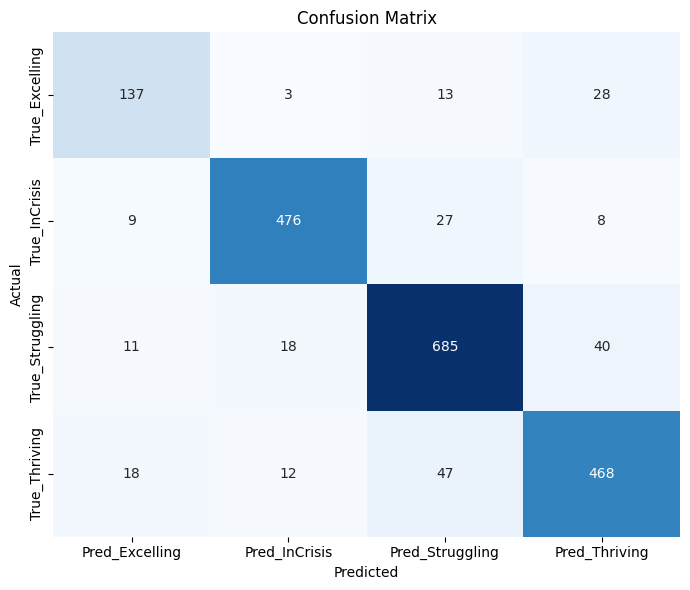


🌀 Classification Report (Shuffled Labels Baseline):



,precision,recall,f1-score,support
Excelling,0.065,0.122,0.085,181.000
InCrisis,0.269,0.265,0.267,520.000
Struggling,0.388,0.342,0.364,754.000
Thriving,0.268,0.239,0.252,545.000
accuracy,0.274,0.274,0.274,0.274
macro avg,0.248,0.242,0.242,2000.000
weighted avg,0.295,0.274,0.283,2000.000


In [7]:
# --- Cross-Validation Results ---
cv_results_df = pd.DataFrame(grid_search_dt.cv_results_)
cv_summary = cv_results_df[['mean_test_score', 'std_test_score', 'params']] \
    .sort_values(by='mean_test_score', ascending=False) \
    .reset_index(drop=True)

print("\n✅ Cross-Validation Results Summary:\n")
display(cv_summary)

# --- Predictions on Test Set ---
y_pred = grid_search_dt.predict(X_test)

# Decode labels back to class names
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)
class_names = le.classes_

# --- Classification Report ---
report_dict = classification_report(
    y_test_labels, y_pred_labels, labels=class_names,
    output_dict=True, zero_division=0
)
report_df = pd.DataFrame(report_dict).T

print("\n📊 Classification Report (Test Set):\n")
display(report_df.round(3))

# --- Balanced Accuracy ---
bal_acc = balanced_accuracy_score(y_test_labels, y_pred_labels)
print(f"\n⚖️ Balanced Accuracy: {bal_acc:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=class_names)

cm_df = pd.DataFrame(
    cm, index=[f"True_{cls}" for cls in class_names],
    columns=[f"Pred_{cls}" for cls in class_names]
)

print("\n🔎 Confusion Matrix:\n")
display(cm_df)

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Shuffled Labels Baseline ---
from sklearn.utils import shuffle
baseline_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

y_shuffled = shuffle(y_train, random_state=42)
baseline_model.fit(X_train, y_shuffled)
y_pred_shuffled = baseline_model.predict(X_test)

y_pred_shuffled_labels = le.inverse_transform(y_pred_shuffled)

baseline_report_dict = classification_report(
    y_test_labels, y_pred_shuffled_labels,
    labels=class_names, output_dict=True, zero_division=0
)
baseline_report_df = pd.DataFrame(baseline_report_dict).T

print("\n🌀 Classification Report (Shuffled Labels Baseline):\n")
display(baseline_report_df.round(3))
